## Sanity checks: Turkish NLI datasets (from Hugging Face Hub)

In [1]:
from __future__ import annotations

from collections import Counter

from datasets import get_dataset_config_names, load_dataset
from huggingface_hub import get_token

REPO_ID = "yilmazzey/sdp2-nli"
CONFIGS = ["snli_tr_1_1", "multinli_tr_1_1", "trglue_mnli"]

# Make sure we can access private repos (token should be cached from `huggingface-cli login`).
assert get_token(), "No cached HF token found. Run `huggingface-cli login` in a terminal."

print("Available configs on hub:", get_dataset_config_names(REPO_ID))

/Users/zeynep_yilmaz/Desktop/Turkish_NLI/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available configs on hub: ['snli_tr_1_1', 'multinli_tr_1_1', 'trglue_mnli']


In [2]:
def load_all(repo_id: str = REPO_ID):
    out = {}
    for cfg in CONFIGS:
        print(f"Loading {repo_id} :: {cfg} ...")
        out[cfg] = load_dataset(repo_id, cfg)
        print("  splits:", list(out[cfg].keys()))
    return out

hub_datasets = load_all()

Loading yilmazzey/sdp2-nli :: snli_tr_1_1 ...
  splits: ['train', 'validation', 'test']
Loading yilmazzey/sdp2-nli :: multinli_tr_1_1 ...
  splits: ['train', 'validation_matched', 'validation_mismatched']
Loading yilmazzey/sdp2-nli :: trglue_mnli ...
  splits: ['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched']


In [3]:
def basic_report(name: str, dsdict):
    print(f"\n## {name}")
    for split, ds in dsdict.items():
        print(f"- {split}: rows={ds.num_rows}")
        print("  columns:", ds.column_names)
        if "label" in ds.column_names:
            labels = ds["label"]
            counts = Counter(labels)
            print("  label_counts (id->count):", dict(sorted(counts.items())))
            # show names if ClassLabel
            if hasattr(ds.features.get("label"), "names"):
                names = ds.features["label"].names
                print("  label_names:", names)
        print("  sample:", ds[0])

for cfg, dsdict in hub_datasets.items():
    basic_report(cfg, dsdict)


## snli_tr_1_1
- train: rows=549367
  columns: ['annotator_labels', 'captionID', 'pairID', 'translation_annotations', 'premise', 'hypothesis', 'label']
  label_counts (id->count): {0: 183416, 1: 182764, 2: 183187}
  label_names: ['entailment', 'neutral', 'contradiction']
  sample: {'annotator_labels': ['neutral'], 'captionID': '3416050480.jpg#4', 'pairID': '3416050480.jpg#4r1n', 'translation_annotations': None, 'premise': 'Attaki bir kişi, bozuk bir uçağın üzerinden atlar.', 'hypothesis': 'Bir kişi atını yarışma için eğitiyor.', 'label': 1}
- validation: rows=9842
  columns: ['annotator_labels', 'captionID', 'pairID', 'translation_annotations', 'premise', 'hypothesis', 'label']
  label_counts (id->count): {0: 3329, 1: 3235, 2: 3278}
  label_names: ['entailment', 'neutral', 'contradiction']
  sample: {'annotator_labels': ['neutral', 'entailment', 'neutral', 'neutral', 'neutral'], 'captionID': '4705552913.jpg#2', 'pairID': '4705552913.jpg#2r1n', 'translation_annotations': None, 'premise

In [4]:
# Convenience: ready-to-use handles for your project
snli = hub_datasets["snli_tr_1_1"]
multinli = hub_datasets["multinli_tr_1_1"]
trglue_mnli = hub_datasets["trglue_mnli"]

# Common schema quick-check
for name, dsd in [("snli", snli), ("multinli", multinli), ("trglue_mnli", trglue_mnli)]:
    split0 = list(dsd.keys())[0]
    cols = dsd[split0].column_names
    assert "premise" in cols and "hypothesis" in cols and "label" in cols, (name, cols)

print("Ready: snli, multinli, trglue_mnli")

Ready: snli, multinli, trglue_mnli


In [5]:
# ---- Paper-aligned expectations (Budur et al., 2020) ----
# These are the canonical example counts for the original SNLI and MultiNLI splits,
# and they should match SNLI-TR / MultiNLI-TR if splits were preserved.
EXPECTED_SPLIT_SIZES = {
    "snli_tr_1_1": {"train": 549_367, "validation": 9_842, "test": 9_824},
    "multinli_tr_1_1": {
        "train": 392_702,
        "validation_matched": 9_815,
        "validation_mismatched": 9_832,
    },
    # TrGLUE MNLI isn't part of the Boğaziçi paper; we still assert what we downloaded from the Hub.
    "trglue_mnli": {
        "train": 165_212,
        "validation_matched": 9_200,
        "validation_mismatched": 9_200,
        "test_matched": 9_200,
        "test_mismatched": 9_217,
    },
}

for cfg, expected in EXPECTED_SPLIT_SIZES.items():
    dsd = hub_datasets[cfg]
    for split, n in expected.items():
        assert split in dsd, (cfg, "missing_split", split)
        assert dsd[split].num_rows == n, (cfg, split, dsd[split].num_rows, "!=" , n)

print("Split-size checks passed for all configs.")

Split-size checks passed for all configs.


In [6]:
# ---- Duplicate + split overlap checks ----

def count_dups_by_key(ds, key: str, *, batch_size: int = 50_000):
    """Returns (n_rows, n_unique, n_duplicates)."""
    seen = set()
    dups = 0
    for start in range(0, ds.num_rows, batch_size):
        vals = ds[key][start : start + batch_size]
        for v in vals:
            if v in seen:
                dups += 1
            else:
                seen.add(v)
    return ds.num_rows, len(seen), dups


def overlap_by_key(ds_a, ds_b, key: str, *, batch_size: int = 50_000):
    seen = set()
    for start in range(0, ds_a.num_rows, batch_size):
        for v in ds_a[key][start : start + batch_size]:
            seen.add(v)

    overlap = 0
    for start in range(0, ds_b.num_rows, batch_size):
        for v in ds_b[key][start : start + batch_size]:
            if v in seen:
                overlap += 1
    return overlap


# SNLI-TR: check duplicates by pairID within each split and overlaps across splits
snli_dsd = hub_datasets["snli_tr_1_1"]
for split in ["train", "validation", "test"]:
    n, u, d = count_dups_by_key(snli_dsd[split], "pairID")
    print("snli_tr_1_1", split, "pairID", f"rows={n} unique={u} dups={d}")

print(
    "snli overlaps (pairID):",
    "train∩val=",
    overlap_by_key(snli_dsd["train"], snli_dsd["validation"], "pairID"),
    "train∩test=",
    overlap_by_key(snli_dsd["train"], snli_dsd["test"], "pairID"),
    "val∩test=",
    overlap_by_key(snli_dsd["validation"], snli_dsd["test"], "pairID"),
)

# MultiNLI-TR: check duplicates by pairID within each split and overlaps across splits
mnli_dsd = hub_datasets["multinli_tr_1_1"]
for split in ["train", "validation_matched", "validation_mismatched"]:
    n, u, d = count_dups_by_key(mnli_dsd[split], "pairID")
    print("multinli_tr_1_1", split, "pairID", f"rows={n} unique={u} dups={d}")

print(
    "multinli overlaps (pairID):",
    "train∩matched=",
    overlap_by_key(mnli_dsd["train"], mnli_dsd["validation_matched"], "pairID"),
    "train∩mismatched=",
    overlap_by_key(mnli_dsd["train"], mnli_dsd["validation_mismatched"], "pairID"),
    "matched∩mismatched=",
    overlap_by_key(mnli_dsd["validation_matched"], mnli_dsd["validation_mismatched"], "pairID"),
)

print("Duplicate/overlap checks complete.")

snli_tr_1_1 train pairID rows=549367 unique=549367 dups=0
snli_tr_1_1 validation pairID rows=9842 unique=9842 dups=0
snli_tr_1_1 test pairID rows=9824 unique=9824 dups=0
snli overlaps (pairID): train∩val= 0 train∩test= 0 val∩test= 0
multinli_tr_1_1 train pairID rows=392702 unique=384286 dups=8416
multinli_tr_1_1 validation_matched pairID rows=9815 unique=9815 dups=0
multinli_tr_1_1 validation_mismatched pairID rows=9832 unique=9805 dups=27
multinli overlaps (pairID): train∩matched= 298 train∩mismatched= 0 matched∩mismatched= 0
Duplicate/overlap checks complete.


In [7]:
# ---- Stronger duplicate/leakage check (exact row match) ----
# For MultiNLI(-TR), `pairID` is not always unique; a safer check is exact matches on (premise,hypothesis,label).

import hashlib


def row_sig(premise: str, hypothesis: str, label: int) -> bytes:
    h = hashlib.blake2b(digest_size=16)
    h.update(premise.encode("utf-8"))
    h.update(b"\0")
    h.update(hypothesis.encode("utf-8"))
    h.update(b"\0")
    h.update(str(label).encode("utf-8"))
    return h.digest()


def count_exact_dups(ds, *, batch_size: int = 20_000):
    seen = set()
    dups = 0
    for start in range(0, ds.num_rows, batch_size):
        batch = ds[start : start + batch_size]
        for i in range(len(batch["premise"])):
            s = row_sig(batch["premise"][i], batch["hypothesis"][i], batch["label"][i])
            if s in seen:
                dups += 1
            else:
                seen.add(s)
    return ds.num_rows, len(seen), dups


def overlap_exact(ds_a, ds_b, *, batch_size: int = 20_000):
    seen = set()
    for start in range(0, ds_a.num_rows, batch_size):
        batch = ds_a[start : start + batch_size]
        for i in range(len(batch["premise"])):
            seen.add(row_sig(batch["premise"][i], batch["hypothesis"][i], batch["label"][i]))

    overlap = 0
    for start in range(0, ds_b.num_rows, batch_size):
        batch = ds_b[start : start + batch_size]
        for i in range(len(batch["premise"])):
            overlap += int(
                row_sig(batch["premise"][i], batch["hypothesis"][i], batch["label"][i])
                in seen
            )
    return overlap


# MultiNLI-TR exact duplicates within splits
mnli_dsd = hub_datasets["multinli_tr_1_1"]
for split in ["train", "validation_matched", "validation_mismatched"]:
    n, u, d = count_exact_dups(mnli_dsd[split])
    print("multinli_tr_1_1", split, f"rows={n} unique={u} exact_dups={d}")

print(
    "multinli exact overlap:",
    "train∩matched=",
    overlap_exact(mnli_dsd["train"], mnli_dsd["validation_matched"]),
    "train∩mismatched=",
    overlap_exact(mnli_dsd["train"], mnli_dsd["validation_mismatched"]),
    "matched∩mismatched=",
    overlap_exact(mnli_dsd["validation_matched"], mnli_dsd["validation_mismatched"]),
)

print("Exact duplicate/leakage checks complete.")

multinli_tr_1_1 train rows=392702 unique=392599 exact_dups=103
multinli_tr_1_1 validation_matched rows=9815 unique=9811 exact_dups=4
multinli_tr_1_1 validation_mismatched rows=9832 unique=9828 exact_dups=4
multinli exact overlap: train∩matched= 2 train∩mismatched= 3 matched∩mismatched= 0
Exact duplicate/leakage checks complete.


In [8]:
# ---- Show actual duplicate/leakage examples (MultiNLI-TR) ----
# This prints representative examples for:
# - exact duplicates within splits
# - exact overlaps across splits (potential leakage)

import hashlib


def _row_sig(premise: str, hypothesis: str, label: int) -> bytes:
    # 16-byte signature (fast + low collision risk for this kind of sanity check)
    h = hashlib.blake2b(digest_size=16)
    h.update(premise.encode("utf-8"))
    h.update(b"\0")
    h.update(hypothesis.encode("utf-8"))
    h.update(b"\0")
    h.update(str(label).encode("utf-8"))
    return h.digest()


def find_exact_dups(ds, *, max_groups: int = 10, batch_size: int = 20_000):
    """Return up to max_groups duplicate groups as (first_idx, dup_idx) pairs."""
    first_idx_by_sig = {}
    found = []

    for start in range(0, ds.num_rows, batch_size):
        batch = ds[start : start + batch_size]
        for i in range(len(batch["premise"])):
            idx = start + i
            sig = _row_sig(batch["premise"][i], batch["hypothesis"][i], batch["label"][i])
            if sig in first_idx_by_sig:
                found.append((first_idx_by_sig[sig], idx))
                if len(found) >= max_groups:
                    return found
            else:
                first_idx_by_sig[sig] = idx

    return found


def build_sig_index(ds, *, batch_size: int = 20_000):
    """Map signature -> first index in ds."""
    idx_by_sig = {}
    for start in range(0, ds.num_rows, batch_size):
        batch = ds[start : start + batch_size]
        for i in range(len(batch["premise"])):
            idx = start + i
            sig = _row_sig(batch["premise"][i], batch["hypothesis"][i], batch["label"][i])
            # keep first occurrence only
            idx_by_sig.setdefault(sig, idx)
    return idx_by_sig


def find_overlaps(train_ds, other_ds, *, max_hits: int = 10, batch_size: int = 20_000):
    """Return up to max_hits overlaps as (train_idx, other_idx) pairs."""
    train_index = build_sig_index(train_ds, batch_size=batch_size)
    hits = []

    for start in range(0, other_ds.num_rows, batch_size):
        batch = other_ds[start : start + batch_size]
        for i in range(len(batch["premise"])):
            other_idx = start + i
            sig = _row_sig(batch["premise"][i], batch["hypothesis"][i], batch["label"][i])
            if sig in train_index:
                hits.append((train_index[sig], other_idx))
                if len(hits) >= max_hits:
                    return hits

    return hits


def pretty_print_pair(ds, idx_a: int, idx_b: int, *, label_feature=None):
    a = ds[idx_a]
    b = ds[idx_b]

    def label_str(x):
        if label_feature is not None and hasattr(label_feature, "int2str"):
            return label_feature.int2str(x)
        return str(x)

    print(f"idx {idx_a} vs {idx_b}")
    print("  label:", a["label"], "(", label_str(a["label"]), ")")
    print("  premise:", a["premise"])
    print("  hypothesis:", a["hypothesis"])
    # show IDs if present
    for k in ["pairID", "promptID", "genre"]:
        if k in a:
            print(f"  {k}:", a[k])


mnli = hub_datasets["multinli_tr_1_1"]
label_feat = mnli["train"].features.get("label")

# 1) within-split duplicates
for split in ["train", "validation_matched", "validation_mismatched"]:
    pairs = find_exact_dups(mnli[split], max_groups=5)
    print(f"\n### Exact duplicates within {split}: showing {len(pairs)} example pairs")
    for a, b in pairs:
        pretty_print_pair(mnli[split], a, b, label_feature=label_feat)
        print("---")

# 2) cross-split overlaps (train ↔ validation splits)
train = mnli["train"]
for other_split in ["validation_matched", "validation_mismatched"]:
    hits = find_overlaps(train, mnli[other_split], max_hits=5)
    print(f"\n### Exact overlaps train ↔ {other_split}: showing {len(hits)} example pairs")
    for train_idx, other_idx in hits:
        print(f"train_idx={train_idx} {other_split}_idx={other_idx}")
        ex = train[train_idx]
        print("  label:", ex["label"], "(", label_feat.int2str(ex["label"]), ")")
        print("  premise:", ex["premise"])
        print("  hypothesis:", ex["hypothesis"])
        print("  train pairID:", ex.get("pairID"))
        print("  other pairID:", mnli[other_split][other_idx].get("pairID"))
        print("---")

print("Done printing sample duplicates/overlaps.")


### Exact duplicates within train: showing 5 example pairs
idx 15145 vs 15146
  label: 2 ( contradiction )
  premise: Sosyoloji Yaşıyor!
  hypothesis: Sosyoloji öldü.
  pairID: 95352c
  promptID: 95352
  genre: slate
---
idx 27295 vs 27296
  label: 2 ( contradiction )
  premise: İsrail geçtiğimiz Mart ayında Arap Doğu Kudüs'te apartman inşa etmeye başladığında, PA güvenliği Hamas'ın terör kanadı operasyonları hakkında istihbarat aktarmayı durdurdu.
  hypothesis: PA güvenliği Hamas'ın terörist kanadı hakkındaki istihbaratı ele geçirmedi.
  pairID: 115747c
  promptID: 115747
  genre: slate
---
idx 13732 vs 32275
  label: 0 ( entailment )
  premise: Tam olarak değil.
  hypothesis: Tam olarak değil.
  pairID: 30639e
  promptID: 30639
  genre: fiction
---
idx 2176 vs 34095
  label: 0 ( entailment )
  premise: Aslan başlı tanrıça Sekhmet (M.Ö. 1400) ve devasa Amenophis IV (1370 M.Ö.).
  hypothesis: Sekhmet aslan kafalı bir tanrıça.
  pairID: 81853e
  promptID: 81853
  genre: travel
---
idx 

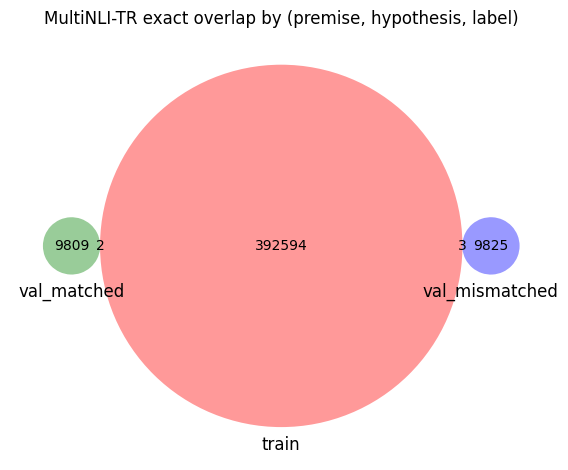

Unique rows:
- train: 392599
- validation_matched: 9811
- validation_mismatched: 9828

Intersections (exact matches):
- train ∩ val_matched: 2
- train ∩ val_mismatched: 3
- val_matched ∩ val_mismatched: 0
- train ∩ val_matched ∩ val_mismatched: 0

Within-split exact duplicates (rows - unique):
- train: 103
- validation_matched: 4
- validation_mismatched: 4


In [9]:
# ---- Venn diagram summary (MNLI) ----
# Summarize overlaps across MultiNLI-TR splits using exact row signatures (premise+hypothesis+label).

from matplotlib import pyplot as plt
from matplotlib_venn import venn3


def sig_set(ds, *, batch_size: int = 20_000):
    s = set()
    for start in range(0, ds.num_rows, batch_size):
        batch = ds[start : start + batch_size]
        for i in range(len(batch["premise"])):
            s.add(_row_sig(batch["premise"][i], batch["hypothesis"][i], batch["label"][i]))
    return s


mnli = hub_datasets["multinli_tr_1_1"]
A = sig_set(mnli["train"])  # unique rows in train
B = sig_set(mnli["validation_matched"])  # unique rows in val_matched
C = sig_set(mnli["validation_mismatched"])  # unique rows in val_mismatched

# region sizes
only_A = len(A - B - C)
only_B = len(B - A - C)
only_C = len(C - A - B)
AB = len((A & B) - C)
AC = len((A & C) - B)
BC = len((B & C) - A)
ABC = len(A & B & C)

plt.figure(figsize=(7, 6))
venn3(subsets=(only_A, only_B, AB, only_C, AC, BC, ABC), set_labels=("train", "val_matched", "val_mismatched"))
plt.title("MultiNLI-TR exact overlap by (premise, hypothesis, label)")
plt.show()

print("Unique rows:")
print("- train:", len(A))
print("- validation_matched:", len(B))
print("- validation_mismatched:", len(C))
print("\nIntersections (exact matches):")
print("- train ∩ val_matched:", len(A & B))
print("- train ∩ val_mismatched:", len(A & C))
print("- val_matched ∩ val_mismatched:", len(B & C))
print("- train ∩ val_matched ∩ val_mismatched:", ABC)

print("\nWithin-split exact duplicates (rows - unique):")
print("- train:", mnli["train"].num_rows - len(A))
print("- validation_matched:", mnli["validation_matched"].num_rows - len(B))
print("- validation_mismatched:", mnli["validation_mismatched"].num_rows - len(C))

In [10]:
# ---- Clarify: overlaps vs within-split duplicates ----
# The Venn diagram is computed on *sets* of unique row signatures per split.
# That means it summarizes cross-split overlap among UNIQUE examples.
# Within-split duplicates are NOT represented in the Venn regions.
#
# This cell checks whether the overlapping signatures are also duplicated within a split.

from collections import Counter


def sig_counts(ds, *, batch_size: int = 20_000):
    counts = Counter()
    for start in range(0, ds.num_rows, batch_size):
        batch = ds[start : start + batch_size]
        for i in range(len(batch["premise"])):
            counts[_row_sig(batch["premise"][i], batch["hypothesis"][i], batch["label"][i])] += 1
    return counts


mnli = hub_datasets["multinli_tr_1_1"]
train = mnli["train"]
vm = mnli["validation_matched"]
vmm = mnli["validation_mismatched"]

train_counts = sig_counts(train)
vm_counts = sig_counts(vm)
vmm_counts = sig_counts(vmm)

overlap_train_vm = set(train_counts) & set(vm_counts)
overlap_train_vmm = set(train_counts) & set(vmm_counts)

print("Exact overlap signatures:")
print("- train ∩ val_matched:", len(overlap_train_vm))
print("- train ∩ val_mismatched:", len(overlap_train_vmm))

print("\nFor each overlap signature, occurrences per split (should be 1 most of the time):")
for name, overlaps in [("train∩val_matched", overlap_train_vm), ("train∩val_mismatched", overlap_train_vmm)]:
    print(f"\n{name} (showing up to 10)")
    for s in list(overlaps)[:10]:
        print(
            "  train=", train_counts[s],
            "val_matched=", vm_counts.get(s, 0),
            "val_mismatched=", vmm_counts.get(s, 0),
        )

# Summaries: how many overlap signatures are duplicated within train?
train_overlap_duped_vm = sum(1 for s in overlap_train_vm if train_counts[s] > 1)
train_overlap_duped_vmm = sum(1 for s in overlap_train_vmm if train_counts[s] > 1)
print("\nOverlap signatures that are ALSO duplicated within train:")
print("- among train∩val_matched:", train_overlap_duped_vm, "of", len(overlap_train_vm))
print("- among train∩val_mismatched:", train_overlap_duped_vmm, "of", len(overlap_train_vmm))

Exact overlap signatures:
- train ∩ val_matched: 2
- train ∩ val_mismatched: 3

For each overlap signature, occurrences per split (should be 1 most of the time):

train∩val_matched (showing up to 10)
  train= 1 val_matched= 1 val_mismatched= 0
  train= 1 val_matched= 1 val_mismatched= 0

train∩val_mismatched (showing up to 10)
  train= 1 val_matched= 0 val_mismatched= 1
  train= 1 val_matched= 0 val_mismatched= 1
  train= 1 val_matched= 0 val_mismatched= 1

Overlap signatures that are ALSO duplicated within train:
- among train∩val_matched: 0 of 2
- among train∩val_mismatched: 0 of 3



## snli_tr_1_1 (trying to reproduce paper Table 2)

- train
  re/unique_sentences (score=329,815): tok=3,971,817 vc=80,695 vu=68,139 unique_sents=599,676 |  paper tok=4,298,183 vc=78,786 vu=66,599 |  delta tok=-326,366 vc=+1,909 vu=+1,540
  ws/unique_sentences (score=382,169): tok=3,959,996 vc=101,188 vu=88,179 unique_sents=599,676 |  paper tok=4,298,183 vc=78,786 vu=66,599 |  delta tok=-338,187 vc=+22,402 vu=+21,580
  ws/premise (score=1,131,692): tok=5,381,497 vc=51,529 vu=45,478 |  paper tok=4,298,183 vc=78,786 vu=66,599 |  delta tok=+1,083,314 vc=-27,257 vu=-21,121
  re/premise (score=1,161,917): tok=5,392,394 vc=41,805 vu=35,874 |  paper tok=4,298,183 vc=78,786 vu=66,599 |  delta tok=+1,094,211 vc=-36,981 vu=-30,725
  re/hypothesis (score=1,394,236): tok=2,918,436 vc=70,823 vu=60,073 |  paper tok=4,298,183 vc=78,786 vu=66,599 |  delta tok=-1,379,747 vc=-7,963 vu=-6,526
  ws/hypothesis (score=1,404,161): tok=2,909,210 vc=85,769 vu=74,804 |  paper tok=4,298,183 vc=78,786 vu=66,599 

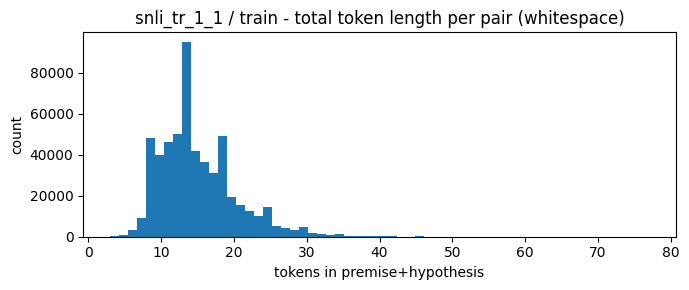


- validation
  re/unique_sentences (score=1,591): tok=87,365 vc=11,604 vu=10,315 unique_sents=12,836 |  paper tok=88,668 vc=11,455 vu=10,176 |  delta tok=-1,303 vc=+149 vu=+139
  ws/unique_sentences (score=4,616): tok=87,114 vc=12,988 vu=11,705 unique_sents=12,836 |  paper tok=88,668 vc=11,455 vu=10,176 |  delta tok=-1,554 vc=+1,533 vu=+1,529
  ws/premise (score=23,804): tok=104,513 vc=7,105 vu=6,567 |  paper tok=88,668 vc=11,455 vu=10,176 |  delta tok=+15,845 vc=-4,350 vu=-3,609
  re/premise (score=25,432): tok=104,793 vc=6,430 vu=5,894 |  paper tok=88,668 vc=11,455 vu=10,176 |  delta tok=+16,125 vc=-5,025 vu=-4,282
  ws/hypothesis (score=38,926): tok=53,017 vc=9,645 vu=8,711 |  paper tok=88,668 vc=11,455 vu=10,176 |  delta tok=-35,651 vc=-1,810 vu=-1,465
  re/hypothesis (score=40,340): tok=53,176 vc=8,864 vu=7,919 |  paper tok=88,668 vc=11,455 vu=10,176 |  delta tok=-35,492 vc=-2,591 vu=-2,257
  -> BEST match: re/unique_sentences (score=1,591)
  pair lengths quantiles (ws, premise+h

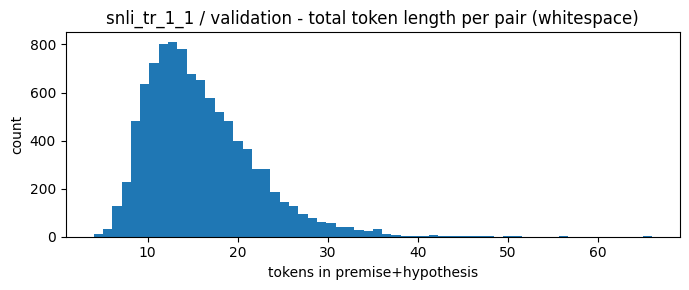


- test
  re/unique_sentences (score=1,678): tok=87,191 vc=11,724 vu=10,418 unique_sents=12,840 |  paper tok=88,533 vc=11,547 vu=10,259 |  delta tok=-1,342 vc=+177 vu=+159
  ws/unique_sentences (score=4,664): tok=86,945 vc=13,083 vu=11,799 unique_sents=12,840 |  paper tok=88,533 vc=11,547 vu=10,259 |  delta tok=-1,588 vc=+1,536 vu=+1,540
  ws/premise (score=23,392): tok=103,780 vc=7,100 vu=6,561 |  paper tok=88,533 vc=11,547 vu=10,259 |  delta tok=+15,247 vc=-4,447 vu=-3,698
  re/premise (score=24,890): tok=104,009 vc=6,471 vu=5,921 |  paper tok=88,533 vc=11,547 vu=10,259 |  delta tok=+15,476 vc=-5,076 vu=-4,338
  ws/hypothesis (score=39,062): tok=52,769 vc=9,707 vu=8,801 |  paper tok=88,533 vc=11,547 vu=10,259 |  delta tok=-35,764 vc=-1,840 vu=-1,458
  re/hypothesis (score=40,497): tok=52,938 vc=8,914 vu=7,990 |  paper tok=88,533 vc=11,547 vu=10,259 |  delta tok=-35,595 vc=-2,633 vu=-2,269
  -> BEST match: re/unique_sentences (score=1,678)
  pair lengths quantiles (ws, premise+hypothe

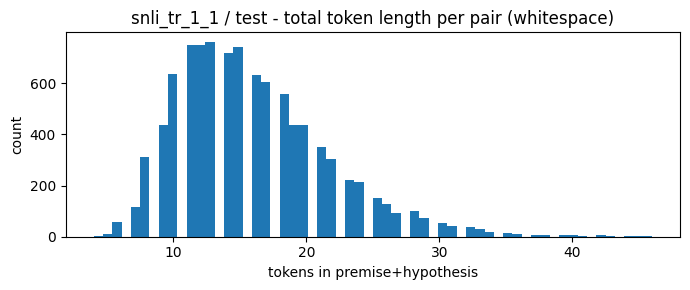


## multinli_tr_1_1 (trying to reproduce paper Table 2)

- train
  re/unique_sentences (score=366,143): tok=4,746,036 vc=225,773 vu=195,190 unique_sents=515,233 |  paper tok=4,397,213 vc=216,590 vu=187,053 |  delta tok=+348,823 vc=+9,183 vu=+8,137
  ws/unique_sentences (score=452,968): tok=4,605,616 vc=341,117 vu=307,091 unique_sents=515,233 |  paper tok=4,397,213 vc=216,590 vu=187,053 |  delta tok=+208,403 vc=+124,527 vu=+120,038
  ws/premise (score=1,212,239): tok=5,579,039 vc=225,899 vu=208,157 |  paper tok=4,397,213 vc=216,590 vu=187,053 |  delta tok=+1,181,826 vc=+9,309 vu=+21,104
  re/premise (score=1,477,097): tok=5,759,838 vc=152,858 vu=136,313 |  paper tok=4,397,213 vc=216,590 vu=187,053 |  delta tok=+1,362,625 vc=-63,732 vu=-50,740
  re/hypothesis (score=1,580,139): tok=2,891,678 vc=176,532 vu=152,507 |  paper tok=4,397,213 vc=216,590 vu=187,053 |  delta tok=-1,505,535 vc=-40,058 vu=-34,546
  ws/hypothesis (score=1,641,870): tok=2,809,284 vc=241,590 vu=215,994 |  paper tok=4,

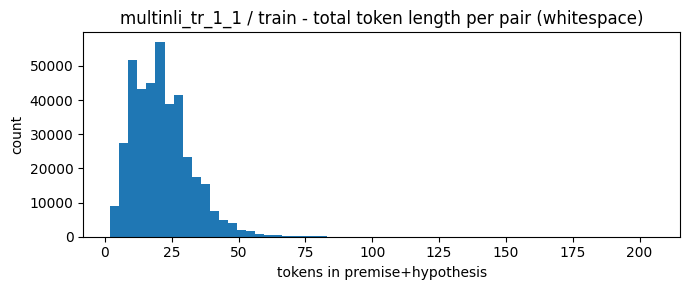


- validation_matched
  re/unique_sentences (score=9,837): tok=120,068 vc=28,558 vu=25,829 unique_sents=13,093 |  paper tok=112,192 vc=27,554 vu=24,872 |  delta tok=+7,876 vc=+1,004 vu=+957
  ws/unique_sentences (score=17,149): tok=116,430 vc=33,997 vu=31,340 unique_sents=13,093 |  paper tok=112,192 vc=27,554 vu=24,872 |  delta tok=+4,238 vc=+6,443 vu=+6,468
  ws/premise (score=38,200): tok=136,655 vc=19,905 vu=18,784 |  paper tok=112,192 vc=27,554 vu=24,872 |  delta tok=+24,463 vc=-7,649 vu=-6,088
  re/premise (score=47,761): tok=141,176 vc=17,446 vu=16,203 |  paper tok=112,192 vc=27,554 vu=24,872 |  delta tok=+28,984 vc=-10,108 vu=-8,669
  ws/hypothesis (score=49,559): tok=70,090 vc=23,384 vu=21,585 |  paper tok=112,192 vc=27,554 vu=24,872 |  delta tok=-42,102 vc=-4,170 vu=-3,287
  re/hypothesis (score=53,033): tok=72,198 vc=20,627 vu=18,760 |  paper tok=112,192 vc=27,554 vu=24,872 |  delta tok=-39,994 vc=-6,927 vu=-6,112
  -> BEST match: re/unique_sentences (score=9,837)
  pair leng

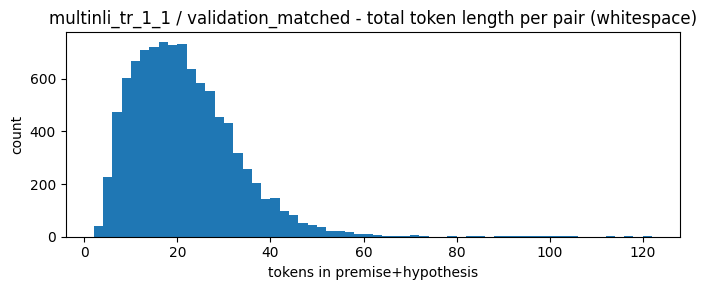


- validation_mismatched
  re/unique_sentences (score=10,984): tok=128,935 vc=27,225 vu=24,782 unique_sents=13,111 |  paper tok=119,691 vc=26,326 vu=23,941 |  delta tok=+9,244 vc=+899 vu=+841
  ws/unique_sentences (score=18,502): tok=124,849 vc=33,001 vu=30,610 unique_sents=13,111 |  paper tok=119,691 vc=26,326 vu=23,941 |  delta tok=+5,158 vc=+6,675 vu=+6,669
  ws/premise (score=35,395): tok=141,986 vc=19,048 vu=18,119 |  paper tok=119,691 vc=26,326 vu=23,941 |  delta tok=+22,295 vc=-7,278 vu=-5,822
  re/premise (score=46,360): tok=147,224 vc=16,226 vu=15,214 |  paper tok=119,691 vc=26,326 vu=23,941 |  delta tok=+27,533 vc=-10,100 vu=-8,727
  ws/hypothesis (score=48,460): tok=76,779 vc=23,240 vu=21,479 |  paper tok=119,691 vc=26,326 vu=23,941 |  delta tok=-42,912 vc=-3,086 vu=-2,462
  re/hypothesis (score=52,115): tok=79,102 vc=20,284 vu=18,457 |  paper tok=119,691 vc=26,326 vu=23,941 |  delta tok=-40,589 vc=-6,042 vu=-5,484
  -> BEST match: re/unique_sentences (score=10,984)
  pair l

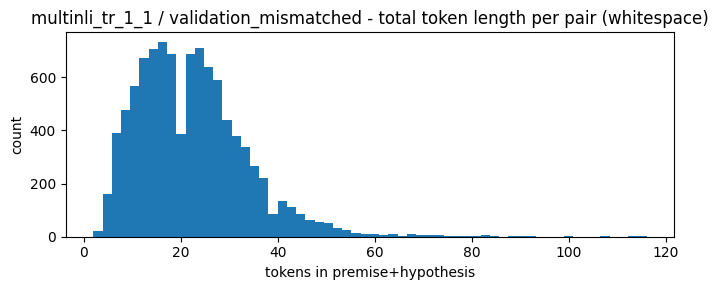

Done.


In [14]:
# ---- Token/vocab + length distributions (compare with paper Table 2) ----
# Goal: match Table 2 as closely as possible by trying a few plausible counting methods.
#
# We try multiple tokenizers + multiple aggregation modes:
# - premise-only
# - hypothesis-only
# - premise+hypothesis (pair)
# - UNIQUE sentences across (premise ∪ hypothesis) within a split (deduplicate repeated sentences)
#
# Then we pick the best match by minimizing absolute deltas vs the paper's (token_count, vocab_cased, vocab_uncased).

import re
import hashlib
import numpy as np
from matplotlib import pyplot as plt


PAPER_TURKISH_TABLE2 = {
    # Token Count, Vocab Size (Cased), Vocab Size (Uncased)
    "snli_tr_1_1": {
        "train": (4_298_183, 78_786, 66_599),
        "validation": (88_668, 11_455, 10_176),
        "test": (88_533, 11_547, 10_259),
    },
    "multinli_tr_1_1": {
        "train": (4_397_213, 216_590, 187_053),
        "validation_matched": (112_192, 27_554, 24_872),
        "validation_mismatched": (119_691, 26_326, 23_941),
    },
}


_word_re = re.compile(r"\w+", flags=re.UNICODE)


def tokenize_ws(text: str):
    return text.split()


def tokenize_re(text: str):
    # word-ish tokenizer; sometimes closer to "token" counts used in papers
    return _word_re.findall(text)


def _sent_sig(text: str) -> bytes:
    # signature for deduplicating sentences
    h = hashlib.blake2b(digest_size=16)
    h.update(text.encode("utf-8"))
    return h.digest()


def token_stats_rows(ds, *, tokenizer, cols, batch_size: int = 10_000):
    """Count tokens/vocab over the dataset rows, aggregating over columns listed in cols."""
    token_count = 0
    vocab_cased = set()
    vocab_uncased = set()
    lengths = np.empty(ds.num_rows, dtype=np.int32)

    out_i = 0
    for start in range(0, ds.num_rows, batch_size):
        batch = ds[start : start + batch_size]
        for j in range(len(batch[cols[0]])):
            total = 0
            for c in cols:
                toks = tokenizer(batch[c][j])
                total += len(toks)
                token_count += len(toks)
                for t in toks:
                    vocab_cased.add(t)
                    vocab_uncased.add(t.lower())
            lengths[out_i] = total
            out_i += 1

    return {
        "token_count": int(token_count),
        "vocab_cased": int(len(vocab_cased)),
        "vocab_uncased": int(len(vocab_uncased)),
        "lengths": lengths,
    }


def token_stats_unique_sentences(ds, *, tokenizer, cols=("premise", "hypothesis"), batch_size: int = 10_000):
    """Count tokens/vocab over UNIQUE sentence strings in the given columns."""
    token_count = 0
    vocab_cased = set()
    vocab_uncased = set()
    lengths = []

    seen = set()
    for start in range(0, ds.num_rows, batch_size):
        batch = ds[start : start + batch_size]
        for j in range(len(batch[cols[0]])):
            for c in cols:
                s = batch[c][j]
                sig = _sent_sig(s)
                if sig in seen:
                    continue
                seen.add(sig)

                toks = tokenizer(s)
                lengths.append(len(toks))
                token_count += len(toks)
                for t in toks:
                    vocab_cased.add(t)
                    vocab_uncased.add(t.lower())

    return {
        "token_count": int(token_count),
        "vocab_cased": int(len(vocab_cased)),
        "vocab_uncased": int(len(vocab_uncased)),
        "lengths": np.array(lengths, dtype=np.int32),
        "n_unique_sentences": int(len(seen)),
    }


def summarize_lengths(lengths: np.ndarray):
    qs = [0, 0.05, 0.25, 0.5, 0.75, 0.95, 1.0]
    vals = np.quantile(lengths, qs)
    return {f"q{int(q*100):02d}": float(v) for q, v in zip(qs, vals)}


def score_vs_paper(cfg: str, split: str, stats: dict):
    ptok, pvc, pvu = PAPER_TURKISH_TABLE2[cfg][split]
    return abs(stats["token_count"] - ptok) + abs(stats["vocab_cased"] - pvc) + abs(stats["vocab_uncased"] - pvu)


def print_comp(cfg: str, split: str, label: str, stats: dict):
    ptok, pvc, pvu = PAPER_TURKISH_TABLE2[cfg][split]
    extra = f" unique_sents={stats.get('n_unique_sentences', '-'):,}" if "n_unique_sentences" in stats else ""
    print(
        f"  {label}: tok={stats['token_count']:,} vc={stats['vocab_cased']:,} vu={stats['vocab_uncased']:,}{extra} | ",
        f"paper tok={ptok:,} vc={pvc:,} vu={pvu:,} | ",
        f"delta tok={stats['token_count']-ptok:+,} vc={stats['vocab_cased']-pvc:+,} vu={stats['vocab_uncased']-pvu:+,}",
    )


TOKENIZERS = {
    "ws": tokenize_ws,
    "re": tokenize_re,
}

ROW_AGGS = {
    "premise": ("premise",),
    "hypothesis": ("hypothesis",),
    "pair": ("premise", "hypothesis"),
}


for cfg in ["snli_tr_1_1", "multinli_tr_1_1"]:
    print(f"\n## {cfg} (trying to reproduce paper Table 2)")
    dsd = hub_datasets[cfg]

    for split, ds in dsd.items():
        if split not in PAPER_TURKISH_TABLE2.get(cfg, {}):
            continue

        print(f"\n- {split}")

        results = []
        for tok_name, tok_fn in TOKENIZERS.items():
            for agg_name, cols in ROW_AGGS.items():
                st = token_stats_rows(ds, tokenizer=tok_fn, cols=cols)
                results.append(((tok_name, agg_name), st, score_vs_paper(cfg, split, st)))

            st_u = token_stats_unique_sentences(ds, tokenizer=tok_fn)
            results.append(((tok_name, "unique_sentences"), st_u, score_vs_paper(cfg, split, st_u)))

        results.sort(key=lambda x: x[2])
        (best_tok, best_mode), best_stats, best_score = results[0]

        for (tok_name, mode), st, sc in results[:6]:
            print_comp(cfg, split, f"{tok_name}/{mode} (score={sc:,})", st)

        print(f"  -> BEST match: {best_tok}/{best_mode} (score={best_score:,})")

        # Also show pair-length distribution (useful for modeling) regardless of which mode matches Table 2
        pair_stats = token_stats_rows(ds, tokenizer=tokenize_ws, cols=("premise", "hypothesis"))
        summ = summarize_lengths(pair_stats["lengths"])
        print("  pair lengths quantiles (ws, premise+hypothesis):", summ)

        plt.figure(figsize=(7, 3))
        plt.hist(pair_stats["lengths"], bins=60)
        plt.title(f"{cfg} / {split} - total token length per pair (whitespace)")
        plt.xlabel("tokens in premise+hypothesis")
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()

print("Done.")

## Özet tablolar (kritik bulgular)

### Split boyutları

| Config | Split | Satır sayısı |
|---|---|---:|
| `snli_tr_1_1` | train | 549,367 |
| `snli_tr_1_1` | validation | 9,842 |
| `snli_tr_1_1` | test | 9,824 |
| `multinli_tr_1_1` | train | 392,702 |
| `multinli_tr_1_1` | validation_matched | 9,815 |
| `multinli_tr_1_1` | validation_mismatched | 9,832 |
| `trglue_mnli` | train | 165,212 |
| `trglue_mnli` | validation_matched | 9,200 |
| `trglue_mnli` | validation_mismatched | 9,200 |
| `trglue_mnli` | test_matched | 9,200 |
| `trglue_mnli` | test_mismatched | 9,217 |

### Kopya (duplicate) ve splitler arası çakışma (overlap)

Not: MultiNLI tarafında `pairID` **benzersiz değil**; bu yüzden kopya/çakışma kontrolünü güvenli olması için **tam eşleşme** ile yaptık: `(premise, hypothesis, label)`.

#### SNLI-TR (`snli_tr_1_1`)

| Kontrol | Sonuç |
|---|---:|
| Split içi duplicate (`pairID`) | 0 |
| Splitler arası overlap (`pairID`) | 0 |

#### MultiNLI-TR (`multinli_tr_1_1`) — exact match `(premise, hypothesis, label)`

| Split | rows | unique | exact_dups |
|---|---:|---:|---:|
| train | 392,702 | 392,599 | 103 |
| validation_matched | 9,815 | 9,811 | 4 |
| validation_mismatched | 9,832 | 9,828 | 4 |

| Kesişim | exact overlap |
|---|---:|
| train ∩ validation_matched | 2 |
| train ∩ validation_mismatched | 3 |
| validation_matched ∩ validation_mismatched | 0 |
| train ∩ validation_matched ∩ validation_mismatched | 0 |

Ek kontrol: overlap olan örneklerin hiçbiri train içinde duplicate grubuna da dahil değil (train’de 1 kez görünüyor).

#### TrGLUE MNLI (`trglue_mnli`) — exact match `(premise, hypothesis, label)`

| Split | rows | unique | exact_dups |
|---|---:|---:|---:|
| train | 165,212 | 162,788 | 2,424 |
| validation_matched | 9,200 | 9,165 | 35 |
| validation_mismatched | 9,200 | 9,200 | 0 |
| test_matched | 9,200 | 9,155 | 45 |
| test_mismatched | 9,217 | 9,217 | 0 |

| Kesişim | exact overlap |
|---|---:|
| train ∩ validation_matched | 115 |
| train ∩ test_matched | 147 |
| validation_matched ∩ test_matched | 31 |

### `validation_matched` / `validation_mismatched` ne demek?

- **matched**: eğitim (train) ile **aynı tür/genre** kaynaklarından gelen örnekler
- **mismatched**: eğitimde görülmeyen **farklı tür/genre** kaynakları (domain shift)

### Paper Table 2 token/vocab sayıları ile eşleştirme

- Basit `premise+hypothesis` whitespace token sayımı paper’daki “Token Count” ile birebir uyuşmuyor.
- En iyi yaklaşım (bu notebookta denenenler içinde): **regex tokenizer + `unique_sentences`** (premise ∪ hypothesis cümlelerini tekilleştirerek saymak).

In [16]:
# ---- Extra: exact match + genre, and swap-insensitive checks (MultiNLI-TR) ----
# 1) Exact match (premise,hypothesis,label) vs (premise,hypothesis,label,genre)
# 2) Swap-insensitive: (premise,hypothesis) reversed pair exists in the same split?

import hashlib


def _h16(*parts: str) -> bytes:
    h = hashlib.blake2b(digest_size=16)
    for p in parts:
        h.update(p.encode("utf-8"))
        h.update(b"\0")
    return h.digest()


def ordered_sig(ex: dict, extra_fields=()):
    parts = [ex["premise"], ex["hypothesis"], str(ex["label"])]
    for f in extra_fields:
        parts.append(str(ex.get(f, "")))
    return _h16(*parts)


def count_ordered_unique(ds, extra_fields=(), batch_size: int = 20_000):
    s = set()
    for start in range(0, ds.num_rows, batch_size):
        batch = ds[start : start + batch_size]
        for i in range(len(batch["premise"])):
            ex = {k: batch[k][i] for k in batch}
            s.add(ordered_sig(ex, extra_fields=extra_fields))
    return ds.num_rows, len(s), ds.num_rows - len(s)


def swap_stats(ds, batch_size: int = 20_000):
    # Count how many unique unordered pairs appear in both directions (p,h) and (h,p).
    seen_dir = {}
    for start in range(0, ds.num_rows, batch_size):
        batch = ds[start : start + batch_size]
        for i in range(len(batch["premise"])):
            p = batch["premise"][i]
            h = batch["hypothesis"][i]
            lab = int(batch["label"][i])
            seen_dir[(p, h)] = lab

    has_swap = 0
    same_label = 0
    diff_label = 0
    for (p, h), lab in seen_dir.items():
        rev = (h, p)
        if rev in seen_dir:
            has_swap += 1
            if seen_dir[rev] == lab:
                same_label += 1
            else:
                diff_label += 1

    # each swap pair counted twice
    return {
        "unique_swap_pairs": has_swap // 2,
        "unique_swap_pairs_same_label": same_label // 2,
        "unique_swap_pairs_diff_label": diff_label // 2,
    }


mnli = hub_datasets["multinli_tr_1_1"]
for split in ["train", "validation_matched", "validation_mismatched"]:
    n, u, d = count_ordered_unique(mnli[split])
    print(f"{split} exact(p,h,label): rows={n} unique={u} dups={d}")

for split in ["train", "validation_matched", "validation_mismatched"]:
    n, u, d = count_ordered_unique(mnli[split], extra_fields=("genre",))
    print(f"{split} exact(p,h,label,genre): rows={n} unique={u} dups={d}")

for split in ["train", "validation_matched", "validation_mismatched"]:
    st = swap_stats(mnli[split])
    print(
        f"{split} swap-insensitive: unique_swap_pairs={st['unique_swap_pairs']} ",
        f"(same_label={st['unique_swap_pairs_same_label']}, diff_label={st['unique_swap_pairs_diff_label']})",
    )

train exact(p,h,label): rows=392702 unique=392599 dups=103
validation_matched exact(p,h,label): rows=9815 unique=9811 dups=4
validation_mismatched exact(p,h,label): rows=9832 unique=9828 dups=4
train exact(p,h,label,genre): rows=392702 unique=392614 dups=88
validation_matched exact(p,h,label,genre): rows=9815 unique=9812 dups=3
validation_mismatched exact(p,h,label,genre): rows=9832 unique=9828 dups=4
train swap-insensitive: unique_swap_pairs=692  (same_label=692, diff_label=0)
validation_matched swap-insensitive: unique_swap_pairs=20  (same_label=20, diff_label=0)
validation_mismatched swap-insensitive: unique_swap_pairs=23  (same_label=23, diff_label=0)


In [ ]:
# ---- Duplicate/leakage checks (TrGLUE MNLI) ----
# Uses exact row signatures (premise+hypothesis+label).

import hashlib


def _sig(premise: str, hypothesis: str, label: int) -> bytes:
    h = hashlib.blake2b(digest_size=16)
    h.update(premise.encode("utf-8"))
    h.update(b"\0")
    h.update(hypothesis.encode("utf-8"))
    h.update(b"\0")
    h.update(str(label).encode("utf-8"))
    return h.digest()


def _sig_set(ds, *, batch_size: int = 20_000):
    s = set()
    for start in range(0, ds.num_rows, batch_size):
        batch = ds[start : start + batch_size]
        for i in range(len(batch["premise"])):
            s.add(_sig(batch["premise"][i], batch["hypothesis"][i], batch["label"][i]))
    return s


def _count_exact_dups(ds, *, batch_size: int = 20_000):
    seen = set()
    dups = 0
    for start in range(0, ds.num_rows, batch_size):
        batch = ds[start : start + batch_size]
        for i in range(len(batch["premise"])):
            s = _sig(batch["premise"][i], batch["hypothesis"][i], batch["label"][i])
            if s in seen:
                dups += 1
            else:
                seen.add(s)
    return ds.num_rows, len(seen), dups


tr = hub_datasets["trglue_mnli"]
splits = list(tr.keys())
print("splits:", splits)

print("\nWithin-split exact duplicates:")
for split in splits:
    n, u, d = _count_exact_dups(tr[split])
    print(f"- {split}: rows={n} unique={u} exact_dups={d}")

sets = {split: _sig_set(tr[split]) for split in splits}

print("\nCross-split exact overlaps (potential leakage):")
for i, a in enumerate(splits):
    for b in splits[i + 1 :]:
        ov = len(sets[a] & sets[b])
        if ov:
            print(f"- {a} ∩ {b}: {ov}")

print("Done.")

splits: ['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched']

Within-split exact duplicates:
- train: rows=165212 unique=162788 exact_dups=2424
- validation_matched: rows=9200 unique=9165 exact_dups=35
- validation_mismatched: rows=9200 unique=9200 exact_dups=0
- test_matched: rows=9200 unique=9155 exact_dups=45
- test_mismatched: rows=9217 unique=9217 exact_dups=0

Cross-split exact overlaps (potential leakage):
- train ∩ validation_matched: 115
- train ∩ test_matched: 147
- validation_matched ∩ test_matched: 31
Done.


## `translation_annotations` dağılım grafikleri (çeviri kalitesi + broken)

Bu bölüm, Hub’daki `snli_tr_1_1` ve `multinli_tr_1_1` datasetlerinden `translation_annotations` alanını okuyup:

- `translation_scores` dağılımı (1–5)
- example-level **broken_any** (en az bir annotator `"broken"` dedi mi?)
- majority-level **broken** (`translation_annotations.gold_label == "broken"`)

grafiklerini üretir.

Not: Train splitleri büyük olduğu için ilk çalıştırma birkaç dakika sürebilir; ama `translation_annotations` olan örnek sayısı çok az olduğu için hesaplanan istatistikler küçük bir örneklem üzerindendir.


=== snli_tr_1_1 ===
annotated coverage: 745/569033 (0.131%)
broken_any counts (examples): {False: 600, True: 145}
majority gold label counts: {'neutral': 248, 'contradiction': 247, 'entailment': 233, 'broken': 17}
translation_scores counts: {1: 5, 2: 103, 3: 274, 4: 573, 5: 2767, 6: 3}


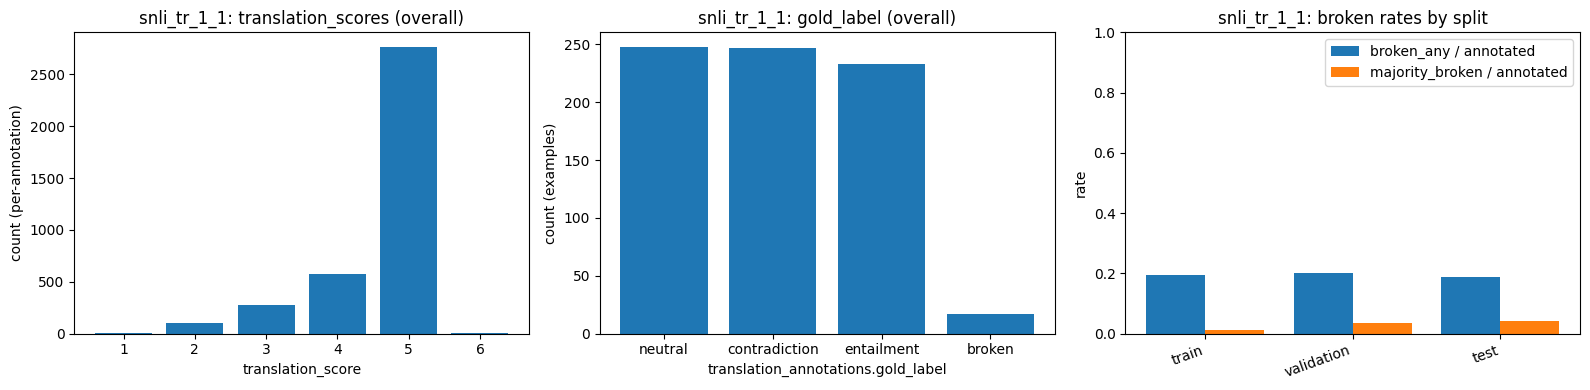


=== multinli_tr_1_1 ===
annotated coverage: 746/412349 (0.181%)
broken_any counts (examples): {False: 562, True: 184}
majority gold label counts: {'contradiction': 240, 'neutral': 245, 'entailment': 236, 'broken': 25}
translation_scores counts: {1: 5, 2: 79, 3: 333, 4: 563, 5: 2749, 6: 1}


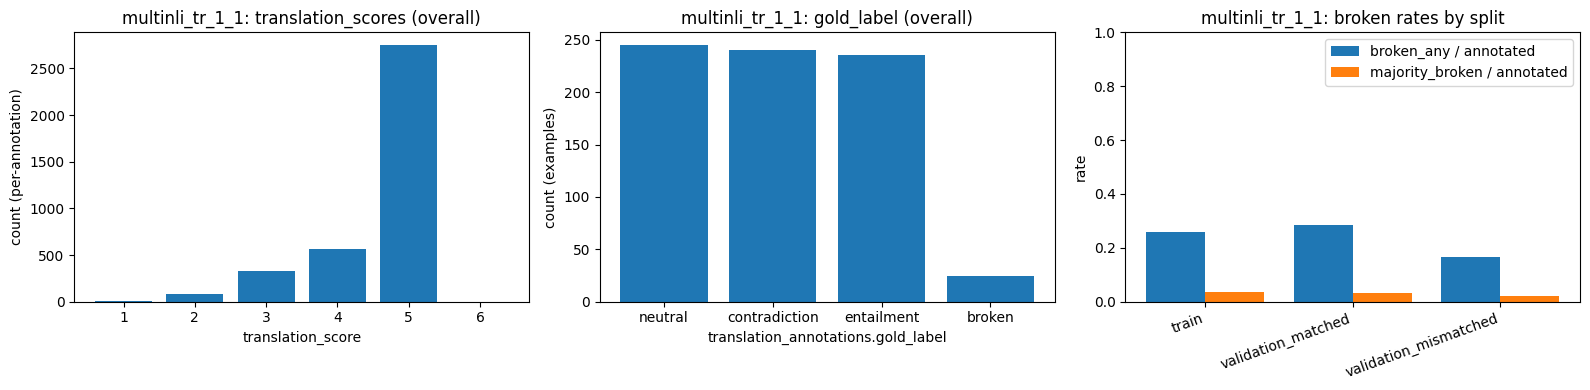

In [17]:
from __future__ import annotations

from collections import Counter

import matplotlib.pyplot as plt
from datasets import load_dataset


REPO = "yilmazzey/sdp2-nli"
CFG_SPLITS = {
    "snli_tr_1_1": ["train", "validation", "test"],
    "multinli_tr_1_1": ["train", "validation_matched", "validation_mismatched"],
}


def is_annotated(ta) -> bool:
    if not isinstance(ta, dict):
        return False
    ids = ta.get("annotator_ids")
    return isinstance(ids, list) and len(ids) > 0


def compute_translation_annotation_stats(ds_split, *, batch_size: int = 50_000):
    """Scan a split and compute stats based on translation_annotations only."""
    total = ds_split.num_rows
    annotated = 0

    score_counts = Counter()  # per-annotation scores
    broken_any_counts = Counter()  # per-example: any annotator labeled 'broken'
    majority_gold_counts = Counter()  # translation_annotations.gold_label distribution

    # Only keep the struct column to reduce I/O
    d = ds_split.select_columns(["translation_annotations"])

    for start in range(0, total, batch_size):
        batch = d[start : start + batch_size]
        tas = batch["translation_annotations"]

        for ta in tas:
            if not is_annotated(ta):
                continue
            annotated += 1

            # scores
            for s in (ta.get("translation_scores") or []):
                try:
                    score_counts[int(s)] += 1
                except Exception:
                    score_counts[str(s)] += 1

            # broken any
            ann_labels = ta.get("annotator_labels") or []
            broken_any_counts[any(lbl == "broken" for lbl in ann_labels)] += 1

            # majority gold
            maj = ta.get("gold_label")
            if maj is not None:
                majority_gold_counts[str(maj)] += 1

    return {
        "total_rows": total,
        "annotated_rows": annotated,
        "annotated_pct": (annotated / total * 100.0) if total else 0.0,
        "score_counts": score_counts,
        "broken_any_counts": broken_any_counts,
        "majority_gold_counts": majority_gold_counts,
    }


def plot_score_dist(ax, score_counts: Counter, title: str):
    # Focus on 1–5, but still show any unexpected keys.
    keys = sorted([k for k in score_counts.keys() if isinstance(k, int)])
    vals = [score_counts[k] for k in keys]
    ax.bar([str(k) for k in keys], vals)
    ax.set_title(title)
    ax.set_xlabel("translation_score")
    ax.set_ylabel("count (per-annotation)")


def plot_broken_rates(ax, stats_by_split: dict, title: str):
    splits = list(stats_by_split.keys())
    broken_any_rate = []
    majority_broken_rate = []

    for sp in splits:
        st = stats_by_split[sp]
        ann = st["annotated_rows"]
        if ann == 0:
            broken_any_rate.append(0.0)
            majority_broken_rate.append(0.0)
            continue

        broken_any = st["broken_any_counts"].get(True, 0)
        majority_broken = st["majority_gold_counts"].get("broken", 0)
        broken_any_rate.append(broken_any / ann)
        majority_broken_rate.append(majority_broken / ann)

    x = range(len(splits))
    ax.bar([i - 0.2 for i in x], broken_any_rate, width=0.4, label="broken_any / annotated")
    ax.bar([i + 0.2 for i in x], majority_broken_rate, width=0.4, label="majority_broken / annotated")
    ax.set_xticks(list(x))
    ax.set_xticklabels(splits, rotation=20, ha="right")
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_ylabel("rate")
    ax.legend()


def plot_majority_gold(ax, majority_counts: Counter, title: str):
    items = majority_counts.most_common()
    labels = [k for k, _ in items]
    vals = [v for _, v in items]
    ax.bar(labels, vals)
    ax.set_title(title)
    ax.set_xlabel("translation_annotations.gold_label")
    ax.set_ylabel("count (examples)")


# Compute + plot
for cfg, splits in CFG_SPLITS.items():
    dsd = load_dataset(REPO, cfg)

    stats_by_split = {}
    overall_scores = Counter()
    overall_majority = Counter()
    overall_broken_any = Counter()
    overall_total = 0
    overall_annotated = 0

    for sp in splits:
        st = compute_translation_annotation_stats(dsd[sp])
        stats_by_split[sp] = st
        overall_scores.update(st["score_counts"])
        overall_majority.update(st["majority_gold_counts"])
        overall_broken_any.update(st["broken_any_counts"])
        overall_total += st["total_rows"]
        overall_annotated += st["annotated_rows"]

    print("\n===", cfg, "===")
    print("annotated coverage:", f"{overall_annotated}/{overall_total} ({overall_annotated/overall_total*100.0:.3f}%)")
    print("broken_any counts (examples):", dict(overall_broken_any))
    print("majority gold label counts:", dict(overall_majority))
    print("translation_scores counts:", dict(sorted((k, v) for k, v in overall_scores.items() if isinstance(k, int))))

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    plot_score_dist(axes[0], overall_scores, f"{cfg}: translation_scores (overall)")
    plot_majority_gold(axes[1], overall_majority, f"{cfg}: gold_label (overall)")
    plot_broken_rates(axes[2], stats_by_split, f"{cfg}: broken rates by split")
    plt.tight_layout()
    plt.show()